Cell Sorting Demo
==================

This notebook demonstrates how to specify, execute and visualize an interactive CC3D simulation of 2D cell sorting in pure Python.

Source: https://github.com/CompuCell3D/CompuCell3D/tree/2e89970bfd51b4e7d4a7f4edb695130f70f97a46/CompuCell3D/core/Demos/CC3DPy/notebooks

Basic Setup
------------------

An interactive CC3D simulation can be initialized from a list of core specs. 
Start a list of core specs that define the simulation by specifying a 
two-dimensional simulation with a 100x100 lattice and second-order Potts neighborhood.

In [1]:
from cc3d.core.PyCoreSpecs import Metadata, PottsCore

specs = [
    Metadata(), 
    PottsCore(dim_x=100, dim_y=100, neighbor_order=2)
]

Cell Types
-----------

Define two cell types called "Condensing" and "NonCondensing".

In [2]:
from cc3d.core.PyCoreSpecs import CellTypePlugin

cell_types = ["Cell_A", "Cell_B"]
specs.append(CellTypePlugin(*cell_types))

Volume Constraint
------------------

Assign a volume constraint to both cell types. 

In [3]:
from cc3d.core.PyCoreSpecs import VolumePlugin

target_volume = 25
lambda_volume = 2

volume_specs = VolumePlugin()
volume_specs.param_new(cell_types[0], target_volume=target_volume, lambda_volume=lambda_volume)
volume_specs.param_new(cell_types[1], target_volume=target_volume, lambda_volume=lambda_volume)
#volume_specs.param_new(cell_types[2], target_volume=target_volume, lambda_volume=-lambda_volume)
specs.append(volume_specs)

Differential Adhesion
----------------------

Assign adhesion between cells by type such that cell sorting occurs. 

In [4]:
from cc3d.core.PyCoreSpecs import ContactPlugin

contact_specs = ContactPlugin(2)
contact_specs.param_new(type_1="Medium", type_2=cell_types[0], energy=10) # Medium Cell_A
contact_specs.param_new(type_1="Medium", type_2=cell_types[1], energy=10) # Medium Cell_B
#contact_specs.param_new(type_1="Medium", type_2=cell_types[2], energy=10) # Medium Cell_C
contact_specs.param_new(type_1=cell_types[0], type_2=cell_types[0], energy=10) # Cell_A Cell_A
contact_specs.param_new(type_1=cell_types[0], type_2=cell_types[1], energy=10) # Cell_A Cell_B
#contact_specs.param_new(type_1=cell_types[0], type_2=cell_types[2], energy=10) # Cell_A Cell_C
contact_specs.param_new(type_1=cell_types[1], type_2=cell_types[1], energy=10) # Cell_B Cell_B
#contact_specs.param_new(type_1=cell_types[1], type_2=cell_types[2], energy=10) # Cell_B Cell_C
#contact_specs.param_new(type_1=cell_types[2], type_2=cell_types[10], energy=10) # Cell_C Cell_C
specs.append(contact_specs)

Cell Distribution Initialization
---------------------------------

Initialize cells as a blob with a random distribution by type. 

In [5]:
from cc3d.core.PyCoreSpecs import BlobInitializer

blob_init_specs = BlobInitializer()
blob_init_specs.region_new(width=5, radius=30, center=(50, 50, 0), cell_types=cell_types)
specs.append(blob_init_specs)

Steppables class (don't change this block unless instructed)
---------------------------------

Initialize a class that allows the user to specify various custom cell and tissue processes. In this case, it accomplishes the task of visualizing the simulation by scanning the lattice and plotting it using matplotlib since the regular CC3D visualization does not work on myBinder. This is a workaround and this is not how simulations are usually visualized in CC3D.

In [6]:
from cc3d.core.PySteppables import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

class visualization(SteppableBasePy):
    def start(self):
        self.fig, self.ax = plt.subplots()  # Create figure and axis
        self.im = None  # Placeholder for image
        #self.cmap = plt.get_cmap("plasma", 4)
        pass
    def step(self, mcs):
        if not mcs % 500:
            self.lattice()
        
    def lattice(self):
        clear_output(wait=True)
        lat = np.zeros(shape=(self.dim.x, self.dim.y, 3))
        self.create_legend()
        for x, y, z in self.every_pixel():
            cell = self.cell_field[x, y, z]
            if cell: 
                R = int(cell.type)*1./len(cell_types)
                G = 1 - int(cell.type)*1./len(cell_types)
                B = np.sin(int(cell.type)*1./len(cell_types)*np.pi)
                color = [R, G, B]
                color = [x * (1-(np.sin(cell.id*10)+1)/20.) for x in color]
                lat[y,x] = color
        if self.im is None:
            #self.im = self.ax.imshow(lat, cmap=self.cmap, vmin=0, vmax=3, animated=True)
            self.im = self.ax.imshow(lat, animated=True)
        else:
            self.im.set_data(lat)
            self.fig.canvas.draw_idle()  # Force a refresh
            self.fig.canvas.flush_events() 
            #self.im = self.ax.imshow(lat, cmap="plasma", vmin=0, vmax=3, animated=True)
        display(self.fig)
        # return(lat)

    def create_legend(self):
        """Creates a discrete legend with fixed colors."""
        legend_labels = {index: value for index, value in enumerate(cell_types)}
        #legend_patches = [Patch(color=self.cmap(i), label=label) for i, label in legend_labels.items()]
        legend_patches = [Patch(color=[(i+1)*1./len(cell_types), 1 - (i+1)*1./len(cell_types), np.sin((i+1)*1./len(cell_types)*np.pi)], label=label) for i, label in legend_labels.items()]
        self.ax.legend(handles=legend_patches, loc="upper right", bbox_to_anchor=(1.3, 1), title="")

C:\Users\pdalc\anaconda3\envs\cc3d_460_310\lib\site-packages\cc3d\core\Configuration\SettingUtils.py:248: UserWarning: Setting not set: PlayerSizes
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')
C:\Users\pdalc\anaconda3\envs\cc3d_460_310\lib\site-packages\cc3d\core\Configuration\SettingUtils.py:248: UserWarning: Setting not set: PlayerSizesFloating
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')
C:\Users\pdalc\anaconda3\envs\cc3d_460_310\lib\site-packages\cc3d\core\Configuration\SettingUtils.py:248: UserWarning: Setting not set: RecentSimulations
  warnings.warn(f'Setting not set: {_el.attrib["Name"]}')


Simulation Launch
------------------

Initialize a CC3D simulation service instance and register all simulation specification. 

In [7]:
from cc3d.CompuCellSetup.CC3DCaller import CC3DSimService

cc3d_sim = CC3DSimService()
cc3d_sim.register_specs(specs)
cc3d_sim.register_steppable(steppable=visualization, frequency=1)
cc3d_sim.run()
cc3d_sim.init()

WILL RUN SIMULATION FROM BEGINNING


True

Visualization
--------------

Show a single frame to visualize simulation data as it is generated. (This here does not work on Binder, that's why I commented it out and implemented a workaround using matplotlib)

In [8]:
#from IPython.display import display

#cc3d_sim.visualize().show()
#display(cc3d_sim.jupyter_run_button())

This alternative way of running CC3D simulations on Binder.

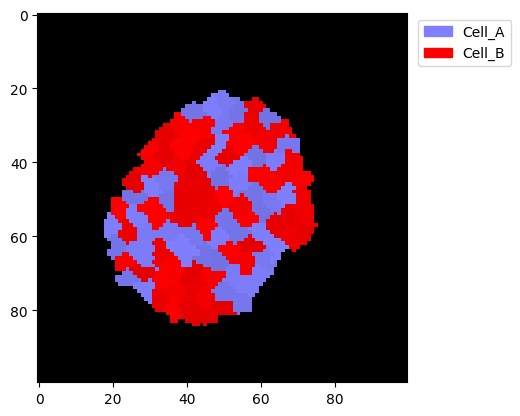

In [9]:
from IPython.display import display, clear_output

cc3d_sim.start()
while cc3d_sim.current_step < 10000:
    cc3d_sim.step()
    
clear_output(wait=True)